In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import  accuracy_score, roc_auc_score ,classification_report ,accuracy_score, precision_score, recall_score, f1_score,confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler , FunctionTransformer
from sklearn.compose import ColumnTransformer
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier ,GradientBoostingClassifier,StackingClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [2]:
df = pd.read_csv("cardio_cleaned.csv")

In [3]:
skew_vals = df.skew().sort_values(ascending=False)
print(skew_vals)


gluc              2.398370
cholesterol       2.171988
lifestyle_risk    2.024995
pulse_pressure    1.002611
BMI               0.895905
ap_hi             0.696026
gender            0.631061
weight            0.565528
ap_lo             0.166126
height            0.086306
cardio            0.002550
age              -0.307035
ap_status        -0.663543
dtype: float64


## Logistic Regression

Train Accuracy: 0.7818605067597816
Test Accuracy: 0.7822661509812348

Train Classification Report:

               precision    recall  f1-score   support

           0       0.74      0.86      0.80     27958
           1       0.84      0.70      0.76     27887

    accuracy                           0.78     55845
   macro avg       0.79      0.78      0.78     55845
weighted avg       0.79      0.78      0.78     55845

Test Classification Report:

               precision    recall  f1-score   support

           0       0.74      0.86      0.80      6990
           1       0.84      0.70      0.76      6972

    accuracy                           0.78     13962
   macro avg       0.79      0.78      0.78     13962
weighted avg       0.79      0.78      0.78     13962

Train AUC: 0.7817556117895832
Test AUC: 0.7821610784031282


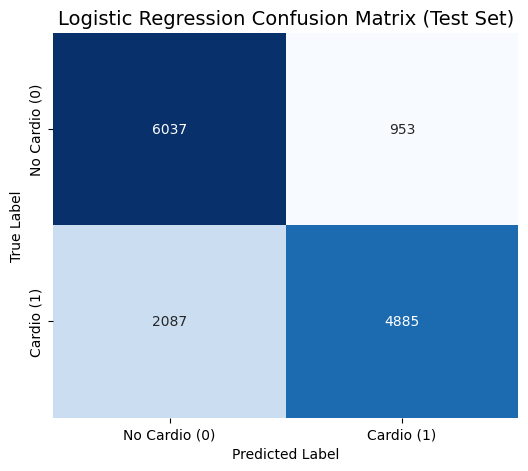

In [4]:
x = df.drop(["cardio"], axis = 1)
y = df["cardio"]
x_train , x_test , y_train , y_test = train_test_split(
    x,
    y, 
    test_size = 0.2,
    random_state = 42,
    stratify= y,
    shuffle = True
    )

skewed_cols = ["ap_hi", "ap_lo", "BMI", "pulse_pressure","height","weight"]
scaled_cols = ["age", "ap_hi", "ap_lo", "BMI", "pulse_pressure","height","weight",]

preprocess = ColumnTransformer(
    transformers=[
        ("log", FunctionTransformer(np.log1p, validate=False), skewed_cols),
        ("scale", StandardScaler(), scaled_cols)
    ],
    remainder='passthrough'
)

pipe = Pipeline([
    ("preprocess", preprocess),
    ("log_reg", LogisticRegression(max_iter = 3000,random_state = 42)),
])

pipe.fit(x_train,y_train)
y_train_pred = pipe.predict(x_train)
y_test_pred = pipe.predict(x_test)

print("Train Accuracy:", accuracy_score(y_train , y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred),end="\n\n")
print("Train Classification Report:\n\n", classification_report(y_train , y_train_pred))
print("Test Classification Report:\n\n", classification_report(y_test , y_test_pred))
print("Train AUC:", roc_auc_score(y_train, y_train_pred))
print("Test AUC:", roc_auc_score(y_test, y_test_pred))

metrics_df = pd.DataFrame({
    "Model": ["Logistic Regression", "Logistic Regression"],
    "Dataset": ["Train", "Test"],
    "Accuracy": [accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)],
    "Precision": [precision_score(y_train, y_train_pred), precision_score(y_test, y_test_pred)],
    "Recall": [recall_score(y_train, y_train_pred), recall_score(y_test, y_test_pred)],
    "F1 Score": [f1_score(y_train, y_train_pred), f1_score(y_test, y_test_pred)],
    "ROC-AUC": [roc_auc_score(y_train, y_train_pred), roc_auc_score(y_test, y_test_pred)]
})
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["No Cardio (0)", "Cardio (1)"],
            yticklabels=["No Cardio (0)", "Cardio (1)"])
plt.title("Logistic Regression Confusion Matrix (Test Set)", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Descision Tree

Train Accuracy: 0.838159190616886
Test Accuracy: 0.8291792006875806

Train Classification Report:

               precision    recall  f1-score   support

           0       0.78      0.94      0.85     27958
           1       0.92      0.74      0.82     27887

    accuracy                           0.84     55845
   macro avg       0.85      0.84      0.84     55845
weighted avg       0.85      0.84      0.84     55845

Test Classification Report:

               precision    recall  f1-score   support

           0       0.77      0.93      0.84      6990
           1       0.91      0.73      0.81      6972

    accuracy                           0.83     13962
   macro avg       0.84      0.83      0.83     13962
weighted avg       0.84      0.83      0.83     13962

Train AUC: 0.8380303455454686
Test AUC: 0.8290512140530238


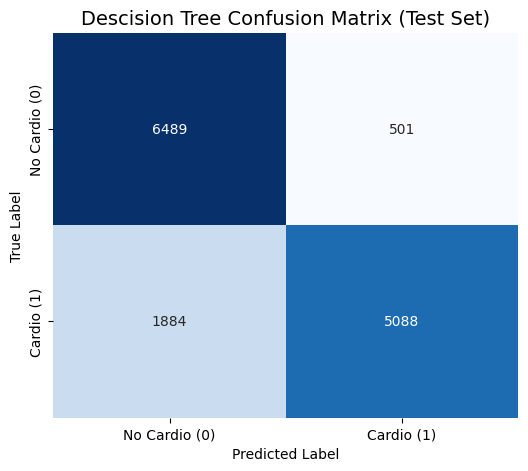

In [5]:
pipe = Pipeline([
    ("preprocess", preprocess),
    ("tree", DecisionTreeClassifier(
        criterion="gini",
        max_depth=15,
        min_samples_split=10,
        random_state=42
    ))
])

pipe.fit(x_train,y_train)

y_train_pred = pipe.predict(x_train)
y_test_pred = pipe.predict(x_test)

tree_metrics = pd.DataFrame({
    "Model": ["Decision Tree", "Decision Tree"],
    "Dataset": ["Train", "Test"],
    "Accuracy": [accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)],
    "Precision": [precision_score(y_train, y_train_pred), precision_score(y_test, y_test_pred)],
    "Recall": [recall_score(y_train, y_train_pred), recall_score(y_test, y_test_pred)],
    "F1 Score": [f1_score(y_train, y_train_pred), f1_score(y_test, y_test_pred)],
    "ROC-AUC": [roc_auc_score(y_train, y_train_pred), roc_auc_score(y_test, y_test_pred)]
})
print("Train Accuracy:", accuracy_score(y_train , y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred),end="\n\n")
print("Train Classification Report:\n\n", classification_report(y_train , y_train_pred))
print("Test Classification Report:\n\n", classification_report(y_test , y_test_pred))
print("Train AUC:", roc_auc_score(y_train, y_train_pred))
print("Test AUC:", roc_auc_score(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["No Cardio (0)", "Cardio (1)"],
            yticklabels=["No Cardio (0)", "Cardio (1)"])
plt.title("Descision Tree Confusion Matrix (Test Set)", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Train Accuracy: 0.8342913421076193
Test Accuracy: 0.8340495630998425

Train Classification Report:

               precision    recall  f1-score   support

           0       0.76      0.97      0.85     27958
           1       0.96      0.69      0.81     27887

    accuracy                           0.83     55845
   macro avg       0.86      0.83      0.83     55845
weighted avg       0.86      0.83      0.83     55845

Test Classification Report:

               precision    recall  f1-score   support

           0       0.76      0.97      0.85      6990
           1       0.96      0.70      0.81      6972

    accuracy                           0.83     13962
   macro avg       0.86      0.83      0.83     13962
weighted avg       0.86      0.83      0.83     13962

Train AUC: 0.8341132702696293
Test AUC: 0.833872645702368


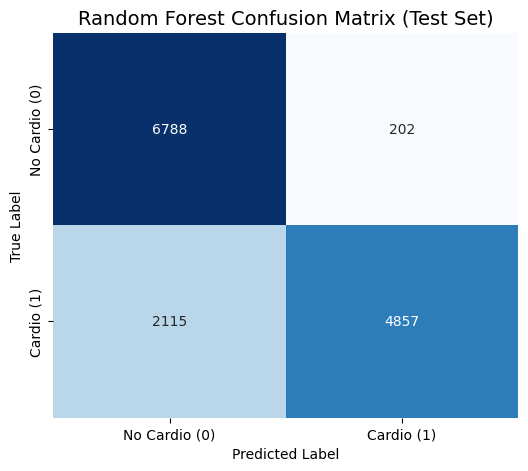

In [6]:
pipe = Pipeline([
    ("preprocess", preprocess),
    ("forest", RandomForestClassifier(
        n_estimators=200,      
        criterion="gini",       
        max_depth=12,           
        min_samples_split=10,   
        random_state=42,
        n_jobs=-1              
    ))
])


pipe.fit(x_train, y_train)

y_train_pred = pipe.predict(x_train)
y_test_pred = pipe.predict(x_test)


rf_metrics = pd.DataFrame({
    "Model": ["Random Forest", "Random Forest"],
    "Dataset": ["Train", "Test"],
    "Accuracy": [accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)],
    "Precision": [precision_score(y_train, y_train_pred), precision_score(y_test, y_test_pred)],
    "Recall": [recall_score(y_train, y_train_pred), recall_score(y_test, y_test_pred)],
    "F1 Score": [f1_score(y_train, y_train_pred), f1_score(y_test, y_test_pred)],
    "ROC-AUC": [roc_auc_score(y_train, y_train_pred), roc_auc_score(y_test, y_test_pred)]
})
print("Train Accuracy:", accuracy_score(y_train , y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred),end="\n\n")
print("Train Classification Report:\n\n", classification_report(y_train , y_train_pred))
print("Test Classification Report:\n\n", classification_report(y_test , y_test_pred))
print("Train AUC:", roc_auc_score(y_train, y_train_pred))
print("Test AUC:", roc_auc_score(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["No Cardio (0)", "Cardio (1)"],
            yticklabels=["No Cardio (0)", "Cardio (1)"])
plt.title("Random Forest Confusion Matrix (Test Set)", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Gradient Boosting

Train Accuracy: 0.8352762109409974
Test Accuracy: 0.8344793009597479

Train Classification Report:

               precision    recall  f1-score   support

           0       0.77      0.96      0.85     27958
           1       0.95      0.71      0.81     27887

    accuracy                           0.84     55845
   macro avg       0.86      0.84      0.83     55845
weighted avg       0.86      0.84      0.83     55845

Test Classification Report:

               precision    recall  f1-score   support

           0       0.77      0.96      0.85      6990
           1       0.95      0.71      0.81      6972

    accuracy                           0.83     13962
   macro avg       0.86      0.83      0.83     13962
weighted avg       0.86      0.83      0.83     13962

Train AUC: 0.8351162853527303
Test AUC: 0.8343166042465385


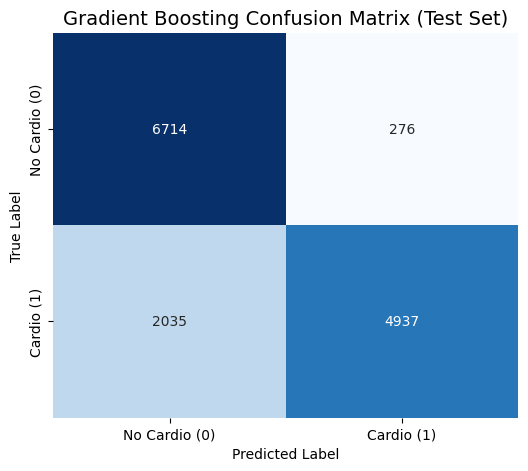

In [7]:
pipe = Pipeline([
    ("preprocess", preprocess),
    ("gb", GradientBoostingClassifier(
        n_estimators=300,       
        learning_rate=0.05,     
        min_samples_split=10,   
        random_state=42
    ))
])


pipe.fit(x_train, y_train)

y_train_pred = pipe.predict(x_train)
y_test_pred = pipe.predict(x_test)

gb_metrics = pd.DataFrame({
    "Model": ["Gradient Boosting", "Gradient Boosting"],
    "Dataset": ["Train", "Test"],
    "Accuracy": [accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)],
    "Precision": [precision_score(y_train, y_train_pred), precision_score(y_test, y_test_pred)],
    "Recall": [recall_score(y_train, y_train_pred), recall_score(y_test, y_test_pred)],
    "F1 Score": [f1_score(y_train, y_train_pred), f1_score(y_test, y_test_pred)],
    "ROC-AUC": [roc_auc_score(y_train, y_train_pred), roc_auc_score(y_test, y_test_pred)]
})

print("Train Accuracy:", accuracy_score(y_train , y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred),end="\n\n")
print("Train Classification Report:\n\n", classification_report(y_train , y_train_pred))
print("Test Classification Report:\n\n", classification_report(y_test , y_test_pred))
print("Train AUC:", roc_auc_score(y_train, y_train_pred))
print("Test AUC:", roc_auc_score(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["No Cardio (0)", "Cardio (1)"],
            yticklabels=["No Cardio (0)", "Cardio (1)"])
plt.title("Gradient Boosting Confusion Matrix (Test Set)", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## XG Boost

Train Accuracy: 0.8452860596293312
Test Accuracy: 0.8348374158430024

Train Classification Report:

               precision    recall  f1-score   support

           0       0.78      0.95      0.86     27958
           1       0.94      0.74      0.83     27887

    accuracy                           0.85     55845
   macro avg       0.86      0.85      0.84     55845
weighted avg       0.86      0.85      0.84     55845

Test Classification Report:

               precision    recall  f1-score   support

           0       0.78      0.94      0.85      6990
           1       0.93      0.73      0.81      6972

    accuracy                           0.83     13962
   macro avg       0.85      0.83      0.83     13962
weighted avg       0.85      0.83      0.83     13962

Train AUC: 0.8451464804335272
Test AUC: 0.8346966037048255


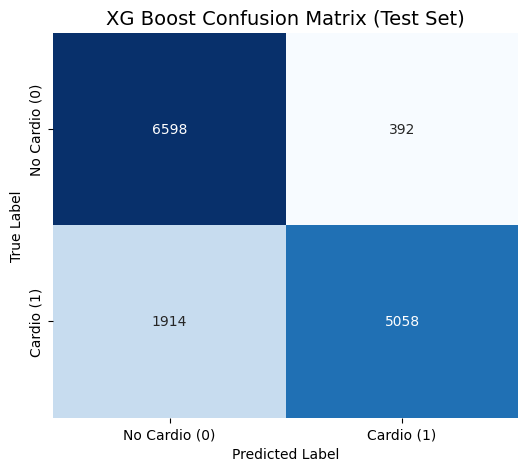

In [8]:
pipe = Pipeline([
    ("preprocess", preprocess),
    ("xgb", XGBClassifier(
        n_estimators=300,        
        learning_rate=0.05,      
        max_depth=6,             
        min_child_weight=5,      
        subsample=0.8,           
        colsample_bytree=0.8,    
        eval_metric="logloss",  
        random_state=42,
        n_jobs=-1,
    ))
])


pipe.fit(x_train, y_train)

y_train_pred = pipe.predict(x_train)
y_test_pred = pipe.predict(x_test)


xgb_metrics = pd.DataFrame({
    "Model": ["XGBoost", "XGBoost"],
    "Dataset": ["Train", "Test"],
    "Accuracy": [accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)],
    "Precision": [precision_score(y_train, y_train_pred), precision_score(y_test, y_test_pred)],
    "Recall": [recall_score(y_train, y_train_pred), recall_score(y_test, y_test_pred)],
    "F1 Score": [f1_score(y_train, y_train_pred), f1_score(y_test, y_test_pred)],
    "ROC-AUC": [roc_auc_score(y_train, y_train_pred), roc_auc_score(y_test, y_test_pred)]
})

print("Train Accuracy:", accuracy_score(y_train , y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred),end="\n\n")
print("Train Classification Report:\n\n", classification_report(y_train , y_train_pred))
print("Test Classification Report:\n\n", classification_report(y_test , y_test_pred))
print("Train AUC:", roc_auc_score(y_train, y_train_pred))
print("Test AUC:", roc_auc_score(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["No Cardio (0)", "Cardio (1)"],
            yticklabels=["No Cardio (0)", "Cardio (1)"])
plt.title("XG Boost Confusion Matrix (Test Set)", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## LGBM

[LightGBM] [Info] Number of positive: 27887, number of negative: 27958
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1483
[LightGBM] [Info] Number of data points in the train set: 55845, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499364 -> initscore=-0.002543
[LightGBM] [Info] Start training from score -0.002543


d:\Anaconda\envs\depi\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\Anaconda\envs\depi\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train Accuracy: 0.8619572029725132
Test Accuracy: 0.8334049563099842

Train Classification Report:

               precision    recall  f1-score   support

           0       0.80      0.97      0.88     27958
           1       0.96      0.76      0.85     27887

    accuracy                           0.86     55845
   macro avg       0.88      0.86      0.86     55845
weighted avg       0.88      0.86      0.86     55845

Test Classification Report:

               precision    recall  f1-score   support

           0       0.78      0.94      0.85      6990
           1       0.92      0.73      0.81      6972

    accuracy                           0.83     13962
   macro avg       0.85      0.83      0.83     13962
weighted avg       0.85      0.83      0.83     13962

Train AUC: 0.8618246854783402
Test AUC: 0.8332685739893972


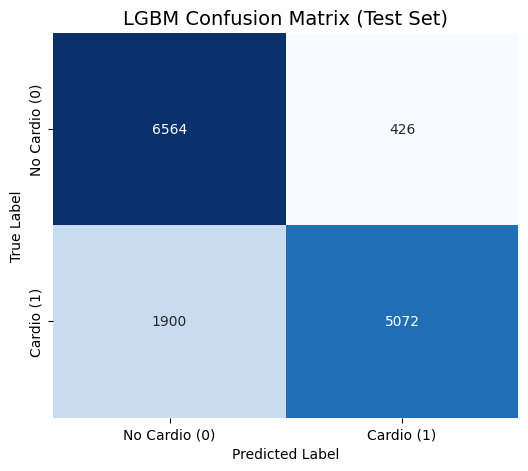

In [9]:
pipe = Pipeline([
    ("preprocess", preprocess),
    ("lgbm", LGBMClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=-1,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    ))
])


pipe.fit(x_train, y_train)

y_train_pred = pipe.predict(x_train)
y_test_pred = pipe.predict(x_test)


lgbm_metrics = pd.DataFrame({
    "Model": ["LightGBM", "LightGBM"],
    "Dataset": ["Train", "Test"],
    "Accuracy": [accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)],
    "Precision": [precision_score(y_train, y_train_pred), precision_score(y_test, y_test_pred)],
    "Recall": [recall_score(y_train, y_train_pred), recall_score(y_test, y_test_pred)],
    "F1 Score": [f1_score(y_train, y_train_pred), f1_score(y_test, y_test_pred)],
    "ROC-AUC": [roc_auc_score(y_train, y_train_pred), roc_auc_score(y_test, y_test_pred)]
})
print("Train Accuracy:", accuracy_score(y_train , y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred),end="\n\n")
print("Train Classification Report:\n\n", classification_report(y_train , y_train_pred))
print("Test Classification Report:\n\n", classification_report(y_test , y_test_pred))
print("Train AUC:", roc_auc_score(y_train, y_train_pred))
print("Test AUC:", roc_auc_score(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["No Cardio (0)", "Cardio (1)"],
            yticklabels=["No Cardio (0)", "Cardio (1)"])
plt.title("LGBM Confusion Matrix (Test Set)", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Cat Boost

Train Accuracy: 0.8445160712686901
Test Accuracy: 0.835195530726257

Train Classification Report:

               precision    recall  f1-score   support

           0       0.78      0.95      0.86     27958
           1       0.94      0.74      0.83     27887

    accuracy                           0.84     55845
   macro avg       0.86      0.84      0.84     55845
weighted avg       0.86      0.84      0.84     55845

Test Classification Report:

               precision    recall  f1-score   support

           0       0.78      0.94      0.85      6990
           1       0.93      0.73      0.81      6972

    accuracy                           0.84     13962
   macro avg       0.85      0.84      0.83     13962
weighted avg       0.85      0.84      0.83     13962

Train AUC: 0.8443783804225001
Test AUC: 0.8350561042453076


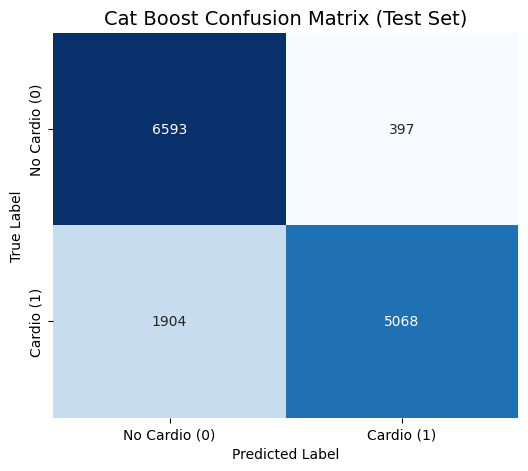

In [10]:
pipe = Pipeline([
    ("preprocess", preprocess),
    ("cat", CatBoostClassifier(
        iterations=500,
        learning_rate=0.05,
        depth=6,
        l2_leaf_reg=3,
        subsample=0.8,
        eval_metric="AUC",
        random_seed=42,
        verbose=False
    ))
])

pipe.fit(x_train, y_train)

y_train_pred = pipe.predict(x_train)
y_test_pred = pipe.predict(x_test)

cat_metrics = pd.DataFrame({
    "Model": ["CatBoost", "CatBoost"],
    "Dataset": ["Train", "Test"],
    "Accuracy": [accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)],
    "Precision": [precision_score(y_train, y_train_pred), precision_score(y_test, y_test_pred)],
    "Recall": [recall_score(y_train, y_train_pred), recall_score(y_test, y_test_pred)],
    "F1 Score": [f1_score(y_train, y_train_pred), f1_score(y_test, y_test_pred)],
    "ROC-AUC": [roc_auc_score(y_train, y_train_pred), roc_auc_score(y_test, y_test_pred)]
})

print("Train Accuracy:", accuracy_score(y_train , y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred),end="\n\n")
print("Train Classification Report:\n\n", classification_report(y_train , y_train_pred))
print("Test Classification Report:\n\n", classification_report(y_test , y_test_pred))
print("Train AUC:", roc_auc_score(y_train, y_train_pred))
print("Test AUC:", roc_auc_score(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["No Cardio (0)", "Cardio (1)"],
            yticklabels=["No Cardio (0)", "Cardio (1)"])
plt.title("Cat Boost Confusion Matrix (Test Set)", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

d:\Anaconda\envs\depi\lib\site-packages\xgboost\training.py:183: UserWarning: [19:33:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\Anaconda\envs\depi\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\Anaconda\envs\depi\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train Accuracy: 0.8441042170292775
Test Accuracy: 0.8362698753760206

Train Classification Report:

               precision    recall  f1-score   support

           0       0.78      0.96      0.86     27958
           1       0.95      0.73      0.82     27887

    accuracy                           0.84     55845
   macro avg       0.86      0.84      0.84     55845
weighted avg       0.86      0.84      0.84     55845

Test Classification Report:

               precision    recall  f1-score   support

           0       0.77      0.95      0.85      6990
           1       0.94      0.72      0.81      6972

    accuracy                           0.84     13962
   macro avg       0.85      0.84      0.83     13962
weighted avg       0.85      0.84      0.83     13962

Train AUC: 0.8439583069208056
Test AUC: 0.8361220479711611


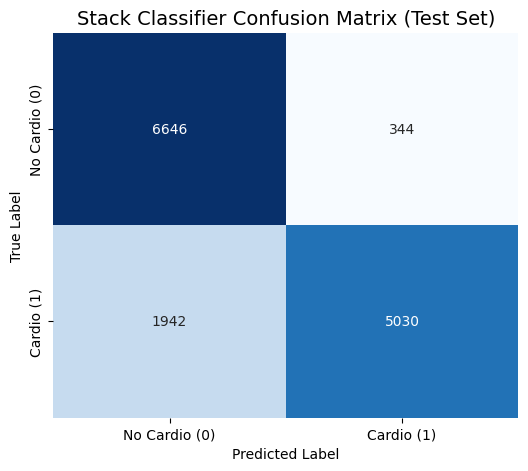

In [13]:
xgb = XGBClassifier(
    n_estimators=300, learning_rate=0.05, max_depth=6,
    subsample=0.8, colsample_bytree=0.8, eval_metric="logloss",
    random_state=42, n_jobs=-1, use_label_encoder=False
)

lgbm = LGBMClassifier(
    n_estimators=500, learning_rate=0.05, subsample=0.8,
    colsample_bytree=0.8, random_state=42, n_jobs=-1
)

cat = CatBoostClassifier(
    iterations=500, learning_rate=0.05, depth=6,
    l2_leaf_reg=3, subsample=0.8, eval_metric="AUC",
    random_seed=42, verbose=False
)

meta_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False
)


stack = StackingClassifier(
    estimators=[
        ("xgb", xgb),
        ("lgbm", lgbm),
        ("cat", cat)
    ],
    final_estimator=meta_model,
    passthrough=True, 
    n_jobs=-1
)


pipe = Pipeline([
    ("preprocess", preprocess),
    ("stack", stack)
])


pipe.fit(x_train, y_train)


y_train_pred = pipe.predict(x_train)
y_test_pred = pipe.predict(x_test)


ensemble_metrics = pd.DataFrame({
    "Model": ["Stacked Ensemble", "Stacked Ensemble"],
    "Dataset": ["Train", "Test"],
    "Accuracy": [accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)],
    "Precision": [precision_score(y_train, y_train_pred), precision_score(y_test, y_test_pred)],
    "Recall": [recall_score(y_train, y_train_pred), recall_score(y_test, y_test_pred)],
    "F1 Score": [f1_score(y_train, y_train_pred), f1_score(y_test, y_test_pred)],
    "ROC-AUC": [roc_auc_score(y_train, y_train_pred), roc_auc_score(y_test, y_test_pred)]
})

print("Train Accuracy:", accuracy_score(y_train , y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred),end="\n\n")
print("Train Classification Report:\n\n", classification_report(y_train , y_train_pred))
print("Test Classification Report:\n\n", classification_report(y_test , y_test_pred))
print("Train AUC:", roc_auc_score(y_train, y_train_pred))
print("Test AUC:", roc_auc_score(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["No Cardio (0)", "Cardio (1)"],
            yticklabels=["No Cardio (0)", "Cardio (1)"])
plt.title("Stack Classifier Confusion Matrix (Test Set)", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [12]:

metrics = pd.concat([
    tree_metrics,
    rf_metrics,
    gb_metrics,
    xgb_metrics,
    lgbm_metrics,
    cat_metrics,
    ensemble_metrics
], ignore_index=True)


metrics


,Model,Dataset,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,Decision Tree,Train,0.838159,0.923783,0.736687,0.819694,0.838030
1,Decision Tree,Test,0.829179,0.910360,0.729776,0.810127,0.829051
2,Random Forest,Train,0.834291,0.964038,0.694051,0.807064,0.834113
3,Random Forest,Test,0.834050,0.960071,0.696644,0.807414,0.833873
4,Gradient Boosting,Train,0.835276,0.947638,0.709327,0.811345,0.835116
5,Gradient Boosting,Test,0.834479,0.947055,0.708118,0.810341,0.834317
6,XGBoost,Train,0.845286,0.942114,0.735361,0.825996,0.845146
7,XGBoost,Test,0.834837,0.928073,0.725473,0.814362,0.834697
8,LightGBM,Train,0.861957,0.957012,0.757593,0.845706,0.861825
9,LightGBM,Test,0.833405,0.922517,0.727481,0.813472,0.833269


# Cat Boost is the most efective model having 72.5% recall and 81.5% f1 score